In [1]:
!pip install psycopg2

In [2]:
import psycopg2
import sys, os
import numpy as np
import pandas as pd
import creds

In [3]:
# Set up a connection to the postgres server.
conn_string = "host="+ creds.PGHOST +" port="+ "5432" +" dbname="+ creds.PGDATABASE +" user=" + creds.PGUSER \
+" password="+ creds.PGPASSWORD
conn=psycopg2.connect(conn_string)
print("Connected!")

# Create a cursor object
cursor = conn.cursor()

Connected!


In [4]:
cursor.execute("""SELECT table_name FROM information_schema.tables
       WHERE table_schema = 'public'""")
for table in cursor.fetchall():
    print(table)

('Banner',)
('Beacon',)
('CandiePrize',)
('BoosterPromotion',)
('BeaconLog',)
('DrawBidTransaction',)
('CandieAd',)
('CandieAdCoupon',)
('CandieAdImpression',)
('CandieSpin',)
('CandieTransactionView',)
('SurpriseCandie',)
('DrawPrizeBucket',)
('CandieTransactionArchive',)
('User',)
('WalletView',)
('CandieTransactionSettlement',)
('Coupon',)
('DrawPeriod',)
('DrawPrize',)
('GIROHistory',)
('Config',)
('Achievement',)
('AcquisitionChannel',)
('Badge',)
('Bank',)
('GlobalNotification',)
('InvoicePatch',)
('Notification',)
('NonPartnerMerchant',)
('Organization',)
('NonPartnerMerchant_MerchantStoreCategory',)
('MerchantShugaRate',)
('Merchant_MerchantStoreCategory',)
('Merchant',)
('Product',)
('ProductCategory',)
('Profile',)
('ReceiptImage',)
('Purchase',)
('Promotion',)
('Receipt',)
('ReceiptProduct',)
('ReceiptProduct_ProductCategory',)
('RedeemProduct',)
('RedeemProduct_ProductCategory',)
('RedeemTransaction',)
('Rule',)
('Store_Product',)
('knex_migrations',)
('ShugaTransactionView

In [5]:
#Get Table columns for Receipts table

cursor.execute('Select * FROM "Receipt" LIMIT 0')
colnames = [desc[0] for desc in cursor.description]
colnames

['id',
 'createdAt',
 'updatedAt',
 'purchaseDate',
 'total',
 'invoiceNo',
 'isReviewed',
 'isGranted',
 'isRejected',
 'comment',
 'store_id_fk',
 'user_id_fk',
 'shugaTransaction_id_fk',
 'candieTransaction_id_fk',
 'merchantName',
 'address',
 'parsedText',
 'isSystemRejected',
 'isUserReport',
 'merchantRegistrationId',
 'merchant_id_fk',
 'nonPartnerMerchant_id_fk',
 'shouldGrantAt',
 'exceptionName',
 'opsComment',
 'reviewedBy',
 'dataQualityScore',
 'userReportType',
 'activeBadges',
 'purchaseRawDate',
 'purchaseRawTime']

In [6]:
#Get Table columns for MerchantStoreCategory table

cursor.execute('Select * FROM "MerchantStoreCategory" LIMIT 0')
colnames = [desc[0] for desc in cursor.description]
colnames

['id', 'createdAt', 'updatedAt', 'name', 'description', 'industry']

In [7]:
#Get Table columns for Merchant_MerchantStoreCategory table

cursor.execute('Select * FROM "Merchant_MerchantStoreCategory" LIMIT 0')
colnames = [desc[0] for desc in cursor.description]
colnames

['id', 'createdAt', 'merchant_id_fk', 'merchantStoreCategory_id_fk']

In [8]:
#Get Table columns for NonPartnerMerchant_MerchantStoreCategory table

cursor.execute('Select * FROM "NonPartnerMerchant_MerchantStoreCategory" LIMIT 0')
colnames = [desc[0] for desc in cursor.description]
colnames

['id', 'createdAt', 'nonPartnerMerchant_id_fk', 'merchantStoreCategory_id_fk']

In [9]:
# Build SQL statement retriving single joined table

sql = \
'\
SELECT "NonPartnerMerchant_MerchantStoreCategory"."merchantStoreCategory_id_fk" AS "merchantStoreCategory_id_fk_x", "Merchant_MerchantStoreCategory"."merchantStoreCategory_id_fk" AS "merchantStoreCategory_id_fk_y", "Receipt".id, "Receipt"."total", "Receipt"."user_id_fk", "Receipt"."merchant_id_fk", "Receipt"."nonPartnerMerchant_id_fk" FROM "Receipt" \
LEFT JOIN "Merchant_MerchantStoreCategory" on "Receipt"."merchant_id_fk" = "Merchant_MerchantStoreCategory"."merchant_id_fk" \
LEFT JOIN "NonPartnerMerchant_MerchantStoreCategory" on "Receipt"."nonPartnerMerchant_id_fk" = "NonPartnerMerchant_MerchantStoreCategory"."nonPartnerMerchant_id_fk"\
WHERE "isGranted" = TRUE \
ORDER BY id \
'

receipts_notclean = pd.read_sql(sql, conn, index_col='id')
storecategory = pd.read_sql('SELECT id AS "merchantStoreCategory_id_fk", "industry" FROM "MerchantStoreCategory" ORDER BY id', conn)

In [10]:
receipts_notclean['merchantStoreCategory_id_fk'] = receipts_notclean[['merchantStoreCategory_id_fk_x','merchantStoreCategory_id_fk_y']].max(axis=1)
receipts = receipts_notclean.dropna(subset=['merchantStoreCategory_id_fk'])
receipts['merchantStoreCategory_id_fk'] = receipts['merchantStoreCategory_id_fk'].astype(int)

C:\Users\Ian\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [11]:
df = receipts.merge(storecategory,on='merchantStoreCategory_id_fk', how = 'left')
df.drop(['merchant_id_fk','merchantStoreCategory_id_fk','merchantStoreCategory_id_fk_x','merchantStoreCategory_id_fk_y','nonPartnerMerchant_id_fk'], axis=1, inplace=True)

In [12]:
df = pd.concat([df, pd.get_dummies(df['industry'])], axis=1)
df.head()

,total,user_id_fk,industry,Automobile,"Baby, Kids & Toys",Book & Stationery,Convenience Store,Departmental Store,Electronics,Fashion,Food,Health and Beauty,Health and Fitness,Hotels & Accommodation,Household,Lifestyle,Services,Supermarket,Transportation,Utilities
0,6.7,3,Food,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
1,4.8,3,Food,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,58.0,8,Food,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
3,39.7,7,Supermarket,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,9.0,6,Food,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0


In [13]:
userdata = df.groupby(['user_id_fk']).sum()
userdata.head()

,total,Automobile,"Baby, Kids & Toys",Book & Stationery,Convenience Store,Departmental Store,Electronics,Fashion,Food,Health and Beauty,Health and Fitness,Hotels & Accommodation,Household,Lifestyle,Services,Supermarket,Transportation,Utilities
user_id_fk,,,,,,,,,,,,,,,,,,
3,606.31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
6,1351.47,0.0,1.0,0.0,0.0,1.0,0.0,4.0,12.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
7,7748.36,0.0,0.0,3.0,1.0,4.0,5.0,7.0,104.0,12.0,0.0,0.0,5.0,2.0,3.0,35.0,0.0,0.0
8,12187.41,0.0,0.0,1.0,5.0,2.0,1.0,9.0,48.0,4.0,0.0,0.0,5.0,1.0,12.0,7.0,1.0,0.0
9,633.02,0.0,0.0,1.0,1.0,1.0,0.0,1.0,12.0,1.0,0.0,0.0,0.0,0.0,0.0,8.0,0.0,0.0


In [14]:
userdata_nototal = userdata.drop(['total'], axis=1)
userdata_nototal.head()

,Automobile,"Baby, Kids & Toys",Book & Stationery,Convenience Store,Departmental Store,Electronics,Fashion,Food,Health and Beauty,Health and Fitness,Hotels & Accommodation,Household,Lifestyle,Services,Supermarket,Transportation,Utilities
user_id_fk,,,,,,,,,,,,,,,,,
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
6,0.0,1.0,0.0,0.0,1.0,0.0,4.0,12.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
7,0.0,0.0,3.0,1.0,4.0,5.0,7.0,104.0,12.0,0.0,0.0,5.0,2.0,3.0,35.0,0.0,0.0
8,0.0,0.0,1.0,5.0,2.0,1.0,9.0,48.0,4.0,0.0,0.0,5.0,1.0,12.0,7.0,1.0,0.0
9,0.0,0.0,1.0,1.0,1.0,0.0,1.0,12.0,1.0,0.0,0.0,0.0,0.0,0.0,8.0,0.0,0.0


In [15]:
from sklearn.cluster import KMeans

In [16]:
# Elbow method

Distortion = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(userdata_nototal)
    Distortion.append(km.inertia_)
    

In [17]:
import matplotlib.pyplot as plt
plt.plot(K, Distortion, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('Elbow Method For Optimal k')
plt.show()

<Figure size 640x480 with 1 Axes>

In [18]:
# set number of clusters
kclusters = 4

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(userdata_nototal)

# add clustering labels
userdata.insert(0, 'Cluster Labels', kmeans.labels_)

userdata.head()

,Cluster Labels,total,Automobile,"Baby, Kids & Toys",Book & Stationery,Convenience Store,Departmental Store,Electronics,Fashion,Food,Health and Beauty,Health and Fitness,Hotels & Accommodation,Household,Lifestyle,Services,Supermarket,Transportation,Utilities
user_id_fk,,,,,,,,,,,,,,,,,,,
3,1,606.31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
6,1,1351.47,0.0,1.0,0.0,0.0,1.0,0.0,4.0,12.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
7,0,7748.36,0.0,0.0,3.0,1.0,4.0,5.0,7.0,104.0,12.0,0.0,0.0,5.0,2.0,3.0,35.0,0.0,0.0
8,1,12187.41,0.0,0.0,1.0,5.0,2.0,1.0,9.0,48.0,4.0,0.0,0.0,5.0,1.0,12.0,7.0,1.0,0.0
9,1,633.02,0.0,0.0,1.0,1.0,1.0,0.0,1.0,12.0,1.0,0.0,0.0,0.0,0.0,0.0,8.0,0.0,0.0


In [19]:
userdata.loc[userdata['Cluster Labels'] == 0].describe()

,Cluster Labels,total,Automobile,"Baby, Kids & Toys",Book & Stationery,Convenience Store,Departmental Store,Electronics,Fashion,Food,Health and Beauty,Health and Fitness,Hotels & Accommodation,Household,Lifestyle,Services,Supermarket,Transportation,Utilities
count,5091.0,5.091000e+03,5091.000000,5091.000000,5091.000000,5091.000000,5091.000000,5091.000000,5091.000000,5091.000000,5091.000000,5091.000000,5091.000000,5091.000000,5091.000000,5091.000000,5091.000000,5091.000000,5091.000000
mean,0.0,1.218784e+04,0.000786,0.685916,1.380475,2.296995,5.079552,0.872324,5.013357,63.619328,7.256924,0.002554,0.018464,5.239049,0.532705,8.548812,62.218621,1.722451,0.021803
std,0.0,5.097460e+04,0.034324,2.076758,2.482632,10.259893,6.944189,1.662779,5.701085,31.294376,6.573058,0.057735,0.268249,5.098366,1.187468,23.702497,34.497446,12.363286,0.213760
min,0.0,3.101900e+02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.0,2.985470e+03,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,2.000000,40.000000,3.000000,0.000000,0.000000,2.000000,0.000000,1.000000,36.000000,0.000000,0.000000
50%,0.0,4.754710e+03,0.000000,0.000000,1.000000,1.000000,3.000000,0.000000,4.000000,60.000000,6.000000,0.000000,0.000000,4.000000,0.000000,3.000000,56.000000,0.000000,0.000000
75%,0.0,7.824110e+03,0.000000,1.000000,2.000000,2.000000,7.000000,1.000000,7.000000,84.000000,10.000000,0.000000,0.000000,7.000000,1.000000,8.000000,82.000000,1.000000,0.000000
max,0.0,1.089358e+06,2.000000,96.000000,83.000000,490.000000,166.000000,65.000000,170.000000,159.000000,81.000000,2.000000,14.000000,60.000000,23.000000,561.000000,181.000000,512.000000,10.000000


In [20]:
userdata.loc[userdata['Cluster Labels'] == 1].describe()

,Cluster Labels,total,Automobile,"Baby, Kids & Toys",Book & Stationery,Convenience Store,Departmental Store,Electronics,Fashion,Food,Health and Beauty,Health and Fitness,Hotels & Accommodation,Household,Lifestyle,Services,Supermarket,Transportation,Utilities
count,19638.0,1.963800e+04,19638.000000,19638.000000,19638.000000,19638.000000,19638.000000,19638.000000,19638.000000,19638.000000,19638.000000,19638.000000,19638.000000,19638.000000,19638.000000,19638.000000,19638.000000,19638.000000,19638.000000
mean,1.0,2.760679e+03,0.008147,0.140951,0.243915,0.451879,0.957633,0.209594,1.112639,9.899277,1.462420,0.000611,0.005449,0.996996,0.126795,1.365159,8.736429,0.218047,0.002342
std,0.0,3.304855e+04,0.608486,0.605009,0.743036,3.523208,3.268538,1.796622,2.098225,11.856204,3.125425,0.026694,0.212222,1.881433,1.137228,6.216660,11.085574,2.289265,0.052387
min,1.0,1.000000e-02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.0,1.103000e+02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
50%,1.0,4.715850e+02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,0.000000,0.000000
75%,1.0,1.356378e+03,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,15.000000,2.000000,0.000000,0.000000,1.000000,0.000000,1.000000,13.000000,0.000000,0.000000
max,1.0,3.109087e+06,64.000000,19.000000,14.000000,212.000000,180.000000,140.000000,49.000000,70.000000,230.000000,2.000000,28.000000,40.000000,82.000000,245.000000,73.000000,224.000000,2.000000


In [21]:
userdata.loc[userdata['Cluster Labels'] == 2].describe()

,Cluster Labels,total,Automobile,"Baby, Kids & Toys",Book & Stationery,Convenience Store,Departmental Store,Electronics,Fashion,Food,Health and Beauty,Health and Fitness,Hotels & Accommodation,Household,Lifestyle,Services,Supermarket,Transportation,Utilities
count,817.0,817.000000,817.000000,817.000000,817.000000,817.000000,817.000000,817.000000,817.000000,817.000000,817.000000,817.000000,817.000000,817.000000,817.000000,817.000000,817.000000,817.000000,817.000000
mean,2.0,27901.305324,0.001224,1.399021,2.821297,5.165239,9.711138,1.776010,10.084455,210.581395,14.102815,0.006120,0.041616,10.795594,1.246022,14.484700,106.529988,3.119951,0.045288
std,0.0,80600.084247,0.034986,2.715677,3.789807,9.188167,8.485847,2.271415,9.105938,90.846326,9.849565,0.078038,0.263333,8.167882,2.058444,31.224913,53.889110,11.436003,0.245859
min,2.0,2018.070000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,119.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.0,7503.940000,0.000000,0.000000,0.000000,0.000000,4.000000,0.000000,4.000000,156.000000,7.000000,0.000000,0.000000,5.000000,0.000000,3.000000,67.000000,0.000000,0.000000
50%,2.0,11012.920000,0.000000,0.000000,2.000000,2.000000,7.000000,1.000000,8.000000,183.000000,12.000000,0.000000,0.000000,9.000000,1.000000,7.000000,101.000000,1.000000,0.000000
75%,2.0,17241.940000,0.000000,2.000000,4.000000,6.000000,13.000000,3.000000,13.000000,235.000000,19.000000,0.000000,0.000000,15.000000,2.000000,15.000000,139.000000,2.000000,0.000000
max,2.0,852069.270000,1.000000,24.000000,51.000000,95.000000,58.000000,27.000000,119.000000,1001.000000,82.000000,1.000000,4.000000,52.000000,22.000000,501.000000,394.000000,174.000000,3.000000


In [22]:
userdata.loc[userdata['Cluster Labels'] == 3].describe()

,Cluster Labels,total,Automobile,"Baby, Kids & Toys",Book & Stationery,Convenience Store,Departmental Store,Electronics,Fashion,Food,Health and Beauty,Health and Fitness,Hotels & Accommodation,Household,Lifestyle,Services,Supermarket,Transportation,Utilities
count,481.0,4.810000e+02,481.0,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000
mean,3.0,3.145561e+04,0.0,0.858628,2.338877,7.480249,8.962578,1.509356,7.326403,97.320166,12.120582,0.006237,0.016632,8.690229,0.758836,24.696466,271.814969,3.083160,0.043659
std,0.0,8.957484e+04,0.0,1.648476,3.251847,26.861608,8.786747,2.191940,6.296453,64.031969,10.244206,0.101871,0.143374,7.895785,1.938656,78.858413,103.215254,12.361118,0.609103
min,3.0,1.986060e+03,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,160.000000,0.000000,0.000000
25%,3.0,8.232450e+03,0.0,0.000000,0.000000,0.000000,3.000000,0.000000,2.000000,51.000000,5.000000,0.000000,0.000000,3.000000,0.000000,3.000000,202.000000,0.000000,0.000000
50%,3.0,1.316005e+04,0.0,0.000000,1.000000,2.000000,6.000000,1.000000,6.000000,88.000000,10.000000,0.000000,0.000000,7.000000,0.000000,7.000000,238.000000,0.000000,0.000000
75%,3.0,2.134336e+04,0.0,1.000000,3.000000,6.000000,12.000000,2.000000,11.000000,128.000000,16.000000,0.000000,0.000000,12.000000,1.000000,16.000000,303.000000,2.000000,0.000000
max,3.0,1.011340e+06,0.0,13.000000,28.000000,471.000000,50.000000,21.000000,36.000000,431.000000,69.000000,2.000000,2.000000,66.000000,32.000000,855.000000,807.000000,165.000000,13.000000


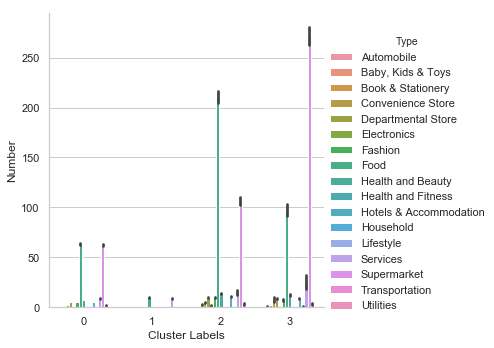

In [23]:
import seaborn as sns

userdatasns = pd.melt(userdata.drop(['total'], axis=1), id_vars='Cluster Labels', var_name='Type', value_name='number')

plt.rcParams['figure.figsize'] = [20, 5]

sns.set(style='whitegrid')
ax = sns.catplot(x='Cluster Labels', y='number', hue='Type', data=userdatasns, kind='bar')
ax.set(xlabel='Cluster Labels', ylabel='Number')

ax.savefig('output.svg', format='svg', dpi=1200)
